In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pandas as pd
from datetime import datetime
import time
import os
import gzip
import numpy as np
from shapely.geometry import Point
import warnings
from tqdm import tqdm
import csv

# Load data from 1980-2020
shapefile_path = "../data/National_USFS_Fire_Occurrence_Point_FL/usfs_fire_occurrence_cleaned_1980_2020.shp"
gdf = gpd.read_file(shapefile_path)

weather = pd.read_csv('../data/weather_data_per_fire.csv')
elevation = pd.read_csv('../data/elevations_per_fire.csv')
merged = weather.merge(elevation, on='OBJECTID').merge(gdf, on='OBJECTID')

In [17]:
# XGBOOST
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

merged['DISCOVERYD'] = pd.to_datetime(merged['DISCOVERYD'], errors='coerce')
merged['FIREOUTDAT'] = pd.to_datetime(merged['FIREOUTDAT'], errors='coerce')
merged['DURATION'] = (merged['FIREOUTDAT'] - merged['DISCOVERYD']).dt.days
merged = merged[merged['DURATION'] >= 0]
merged = merged[merged['DURATION'] <= 300]

# Filter relevant data
weather_data = merged[['TEMPERATURE_AVERAGE', 'PRESSURE', 'WIND_SPEED', 'DURATION', 'PRECIPITATION']].dropna()
# weather_data = merged[['TEMPERATURE_AVERAGE', 'DURATION']].dropna()

# Feature engineering if needed
weather_data['TEMPERATURE_CATEGORY'] = pd.cut(weather_data['TEMPERATURE_AVERAGE'], bins=[0, 20, 40, 60], labels=["Low", "Medium", "High"])

# Define target variable
y = weather_data['DURATION']

# Define predictors
X = weather_data[['TEMPERATURE_AVERAGE', 'PRESSURE', 'WIND_SPEED', 'PRECIPITATION']]

features = ['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']
target = 'DURATION'

data = merged[features + [target]].dropna()

X = data[features]
y = data[target]

y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)   # undo log(1 + x)
y_test_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
r2 = r2_score(y_test_true, y_pred)

print(f"XGBoost Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

XGBoost Model Evaluation:
RMSE: 14.19
R-squared Score: 0.07


Confusion Matrix:
[[498   7]
 [ 29   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       505
           1       0.46      0.17      0.25        35

    accuracy                           0.93       540
   macro avg       0.70      0.58      0.61       540
weighted avg       0.91      0.93      0.92       540



C:\Users\gahot\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:05:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


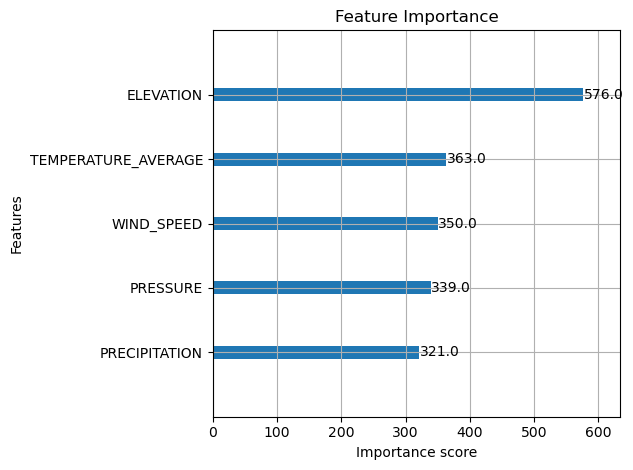

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

merged['IS_LONG_DURATION'] = (merged['DURATION'] > 24).astype(int)

features = ['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']
X = merged[features]
y = merged['IS_LONG_DURATION']

X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plot_importance(model)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

C:\Users\gahot\AppData\Local\Temp\ipykernel_57976\2900506502.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


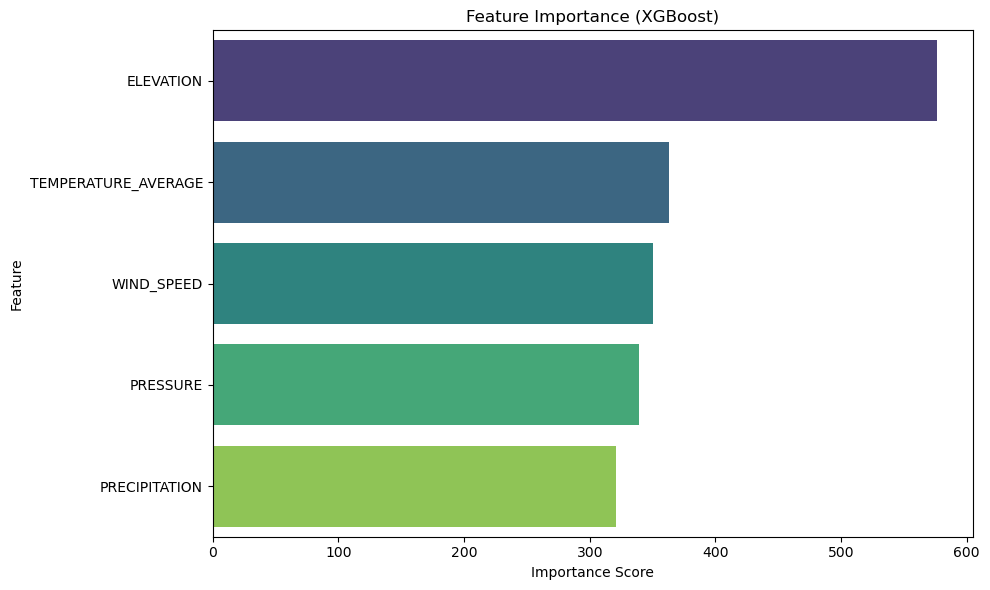

In [23]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you've already trained your regressor as `xgb_model`
importance_dict = model.get_booster().get_score(importance_type='weight')

# 2. Convert to DataFrame
feat_imp_df = (
    pd.DataFrame({
        'Feature': list(importance_dict.keys()),
        'Importance': list(importance_dict.values())
    })
    .sort_values(by='Importance', ascending=False)
)

# 3. Plot with the same style and colors as your RF plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
    palette='viridis'
)
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [13]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters found: ", best_params)

test_rmse = np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))
print("Test RMSE: ", test_rmse)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best hyperparameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Test RMSE:  0.23492513798117862
